In [30]:
# This code is written by Yara Al-Shorman
# Date created: May 18 2022
# Last modified: Jun 2 2022
# Github repo: https://github.com/YaraAlShorman/Research-spring-22
# The purpose of this code is to predict the bulkflows for a large given set of galaxies (using machine learning)

### imports

In [31]:
# imports
import tensorflow as tf
from numpy import load, concatenate, expand_dims  # I am doing this to minimize unncessary imports, they take up too much RAM and time
from sklearn.preprocessing import MinMaxScaler
from math import floor
from matplotlib import pyplot as plt

In [32]:
# run this snippet to disable GPU

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


### checking for GPU

### tangent: running tensorflow with GPU

Tensorflow by default attempts to run on GPU if possible. If the capability to do so was not found, it runs on the CPU. <br>
To allow it to run on the GPU and you are using an NVIDIA graphics card, you must download the THE CORRECT VERSIONS of CUDNN, CUDA, Tensorflow, and Python. <br>
Yes, all of them have to match up. (It took me 2 days to figure that out) <br>
To check if your NVIDIA GPU is compatible (I dont know if this works for AMD GPUs): Refer to https://developer.nvidia.com/cuda-gpus <br>
I have a GTX 1650 TI with Max-Q capability. Which is compatible.<br>
Furthermore, you must ensure you have matching versions of Python, Tensorflow, CUDNN and CUDA. <br>
No, having the newest versions is not enough. <br>
I installed: <br>
CUDNN v11.2 <br>
CUDA v8.1 <br>
Tensorflow v2.9 <br>
Python v3.10 <br>
You also need a compatible version of Visual Studio (MSVC). I have MSVC 2019. <br>
Keep in mind that the newest versions of CUDA and CUDNN are 8.4 and 11.7, respectively. Which will NOT work. Pay careful attention to versions. <br>
Refer to this page for compatible versions: https://www.tensorflow.org/install/source_windows#gpu <br>
Of course, things are different if you are using Mac or Linux <br>

In [33]:
# checking that GPU is available
print(tf.config.list_physical_devices('GPU'))

[]


### data preprocessing

In [34]:
# stacking all of the data into one humungous tensor
# I am using tensors because they can be ragged and can be stacked
# these means we won't have to cut off our data to standardize array sizes
data = load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-0-error-40.npy.npz')
input_data = data['data']
scaler = MinMaxScaler()
scaler.fit(input_data)
input_data = scaler.transform(input_data)
input_data = tf.expand_dims(input_data, axis=0)
input_data = tf.RaggedTensor.from_tensor(input_data)
# if scaling the data this way doesn't work good enough, i can try scaling all the data at once, to one scale
# in this case, i am scaling every 'square' of data seprately
# i should try scaling the entire 'cube' at once

output_data = tf.convert_to_tensor(data['header'])
output_data = tf.expand_dims(output_data, axis=0)

num_of_files = 300  # variable for number of files to load, current limit is 3000

for i in range(1, num_of_files): # limit 3000
        array_data = load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-{i}-error-40.npy.npz')
        # 'data' data
        temp = tf.convert_to_tensor(array_data['data'], dtype='float64')
        scaler = MinMaxScaler()
        scaler.fit(temp)
        temp = scaler.transform(temp)
        temp = tf.expand_dims(temp, axis=0)  # dimensions have to be expandad to be able to concat along the outer-dimension 
        input_data = tf.concat([input_data, temp], axis=0)  # concat adds to existing dimensions, does not create new ones
        # 'input_data' is a tensor
        
        # 'header' data (bulkflows)
        temp = array_data['header']
        temp = expand_dims(temp, axis=0)
        output_data = concatenate([output_data, temp], axis=0)
        # 'output_data' is an array, because it is uniform 
        # i scale it (normalize it) all at once, then i convert it to a tensor
        
# next is scaling

In [35]:
# normalizing/scaling the data
scaler = MinMaxScaler()
scaler.fit(output_data)
output_data = scaler.transform(output_data)
output_data = tf.convert_to_tensor(output_data)

In [36]:
# splitting the data into train/test sections
# 75% -> train
# 25% -> test
train_percent = 0.75
input_train, input_test = (input_data[:floor(num_of_files * train_percent)], \
                                input_data[floor(num_of_files * train_percent)::])
output_train, output_test = (output_data[:floor(num_of_files * train_percent)], \
                                output_data[floor(num_of_files * train_percent)::])

# data is split and ready for the model

### model creation

In [37]:
# optimizer
# 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [38]:
# model creations

model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.InputLayer(input_shape=[None, 4], ragged=True))
model0.add(tf.keras.layers.LSTM(128, dropout=0.25, activation='tanh'))  # tanh is necessary to make GPU accelaration work
# model0.add(tf.keras.layers.Dense(128, activation='selu'))
# model0.add(tf.keras.layers.Dropout(0.5))
# model0.add(tf.keras.layers.Dense(16, activation='selu'))
# model0.add(tf.keras.layers.Dropout(0.5))
model0.add(tf.keras.layers.Dense(32, activation='tanh'))
model0.add(tf.keras.layers.Dropout(0.25))
model0.add(tf.keras.layers.Dense(3, activation='relu'))

model0.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

a = model0.fit(input_train, output_train, epochs=20, use_multiprocessing=True, workers=8)



Epoch 1/20
71/71 [==============================] - 4742s 67s/step - loss: 0.1216 - accuracy: 0.3316
Epoch 2/20
45/71 [==================>...........] - ETA: 22:08 - loss: 0.0296 - accuracy: 0.3479

KeyboardInterrupt: 

### testing & graphing results

In [ ]:
output_pred = model0.predict(input_test)

2/2 [==============================] - 2s 613ms/step


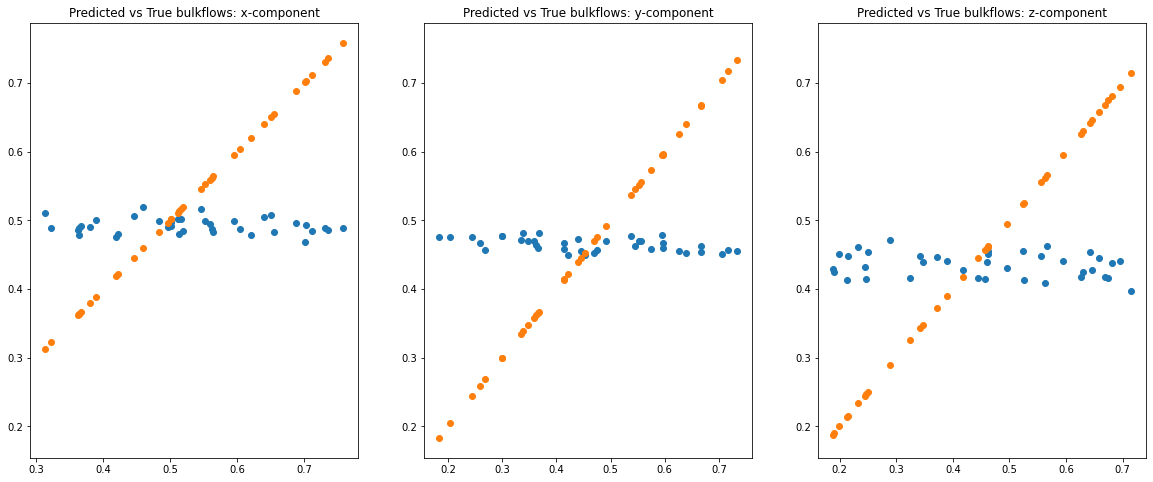

In [ ]:
fig = plt.figure()
fig.set_figheight(8) 
fig.set_figwidth(20)

bx = fig.add_subplot(1, 3, 1)
plt.scatter(output_test[:, 0], output_pred[:, 0])
plt.scatter(output_test[:, 0], output_test[:, 0])
plt.title('Predicted vs True bulkflows: x-component')


by = fig.add_subplot(1, 3, 2, sharey=bx)
plt.scatter(output_test[:, 1], output_pred[:, 1])
plt.scatter(output_test[:, 1], output_test[:, 1])
plt.title('Predicted vs True bulkflows: y-component')

bz = fig.add_subplot(1, 3, 3, sharey=bx)
plt.scatter(output_test[:, 2], output_pred[:, 2])
plt.scatter(output_test[:, 2], output_test[:, 2])
plt.title('Predicted vs True bulkflows: z-component')

plt.show()